# NPK Prediction for SIF Accelerator Program

The objectif for this project is to makes a model prediction for NPK.

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score,recall_score
from sklearn.model_selection import GridSearchCV

#save Model
import pickle

# Data Preparation

In [3]:

# Load the Excel files
file1_path = '01 MacPherson_Rack (22 Dec 2023 to 18 Apr 2024).xlsx'
file2_path = '02 MacPherson_Rack (01 May 2024 to 06 Jun 2024).xlsx'

# Read the Excel files
data1 = pd.read_excel(file1_path)
data2 = pd.read_excel(file2_path)

# Combine datasets
data = pd.concat([data1, data2], ignore_index=True)

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 16', 'Buzzer (NIL)', 'Grams of Compost Harvested'])


In [4]:
data

,Timestamp,Number of Worms (non-counted),Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Light Intensity,Temp01,Hum01,Heat01,SoilM01,SoilM02
0,2023-12-22 10:00:00,20,160,150,120,150,100,94,NaN,28.5,NaN,NaN,1.0,1.0
1,2023-12-22 10:01:00,20,160,150,120,150,100,94,NaN,28.5,NaN,NaN,1.0,1.0
2,2023-12-22 10:02:00,20,160,150,120,150,100,94,NaN,28.5,NaN,NaN,1.0,1.0
3,2023-12-22 10:03:00,20,160,150,120,150,100,94,NaN,28.5,NaN,NaN,1.0,1.0
4,2023-12-22 10:04:00,20,160,150,120,150,100,94,NaN,28.5,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,2024-05-01 23:10:00,20,153,150,161,162,110,109,30.0,27.4,72.0,51.240876,1.0,1.0
889,2024-05-01 23:20:00,20,150,152,166,164,106,105,30.0,27.4,72.0,51.240876,1.0,1.0
890,2024-05-01 23:30:00,20,153,153,167,162,111,106,30.0,27.4,72.0,51.240876,1.0,1.0
891,2024-05-01 23:40:00,20,153,153,164,159,111,106,30.0,27.4,71.0,50.529197,1.0,1.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Timestamp                      893 non-null    datetime64[ns]
 1   Number of Worms (non-counted)  893 non-null    int64         
 2   Phosphorous01                  893 non-null    object        
 3   Phosphorous02                  893 non-null    object        
 4   Nitrogen01                     893 non-null    object        
 5   Nitrogen02                     893 non-null    object        
 6   Potassium01                    893 non-null    object        
 7   Potassium02                    893 non-null    object        
 8   Light Intensity                84 non-null     float64       
 9   Temp01                         521 non-null    float64       
 10  Hum01                          84 non-null     float64       
 11  Heat01             

Its weird that NPK feature were remind object while in the datset they were a number value. Let's check it one by one.

## Check unique value of each feature

In [6]:
data["Phosphorous01"].value_counts()

Phosphorous01
160    667
?      142
147     20
146     17
145     14
152     14
150      7
153      6
151      6
Name: count, dtype: int64

In [7]:
data["Phosphorous02"].value_counts()

Phosphorous02
150    677
?      142
147     21
146     18
145     12
152      9
151      8
153      6
Name: count, dtype: int64

In [8]:
data["Nitrogen01"].value_counts()

Nitrogen01
120    667
?      142
160     12
161      9
159      9
163      8
154      7
157      5
158      5
162      5
155      4
156      4
164      4
165      4
166      3
153      2
167      2
152      1
Name: count, dtype: int64

In [9]:
data["Nitrogen02"].value_counts()

Nitrogen02
150    667
?      142
157     17
162      9
158      9
159      8
163      7
164      6
161      5
160      4
154      4
155      4
156      2
153      2
165      2
166      2
167      2
152      1
Name: count, dtype: int64

In [10]:
data["Potassium01"].value_counts()

Potassium01
100    669
?      142
109     10
106      8
112      8
102      7
107      7
110      7
111      7
104      6
105      6
108      5
103      4
101      3
113      3
114      1
Name: count, dtype: int64

In [11]:
data["Potassium02"].value_counts()

Potassium02
94     667
?      142
106     16
107      9
108      9
104      8
111      7
101      6
105      6
113      6
109      5
110      4
102      3
103      2
112      2
114      1
Name: count, dtype: int64

## Check The Missing Value

In [12]:

# Check for remaining missing values
print(data.isnull().sum())


Timestamp                          0
Number of Worms (non-counted)      0
Phosphorous01                      0
Phosphorous02                      0
Nitrogen01                         0
Nitrogen02                         0
Potassium01                        0
Potassium02                        0
Light Intensity                  809
Temp01                           372
Hum01                            809
Heat01                           809
SoilM01                          256
SoilM02                          256
dtype: int64


From The information above, There is a lot of nan value, and '?' that in this dataset. For next Data preprocessing. We will change the value '?' into NaN, and will fill the handling NaN value interpolation and filling remaining with mean

# Data Processing 

## Change '?' to NaN

In [13]:
#Identify '?' values and replace with NaN
data.replace('?', pd.NA, inplace=True)

In [14]:

# Check for remaining missing values
print(data.isnull().sum())


Timestamp                          0
Number of Worms (non-counted)      0
Phosphorous01                    142
Phosphorous02                    142
Nitrogen01                       142
Nitrogen02                       142
Potassium01                      142
Potassium02                      142
Light Intensity                  809
Temp01                           372
Hum01                            809
Heat01                           809
SoilM01                          256
SoilM02                          256
dtype: int64


Almost more than 80% of nan value in Light Intensity, Hum01, and Heat01

## Change Type data of NPK to Number 

In [15]:
data['Phosphorous01'] = pd.to_numeric(data['Phosphorous01'])
data['Phosphorous02'] = pd.to_numeric(data['Phosphorous02'])
data['Nitrogen01'] = pd.to_numeric(data['Nitrogen01'])
data['Nitrogen02'] = pd.to_numeric(data['Nitrogen02'])
data['Potassium01'] = pd.to_numeric(data['Potassium01'])
data['Potassium02'] = pd.to_numeric(data['Potassium02'])

## Handling Mising Value 

In [16]:
# Identify numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Handle missing values using interpolation and filling remaining with mean
data[numeric_cols] = data[numeric_cols].interpolate(method='linear', limit_direction='both')
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Check for remaining missing values
print(data.isnull().sum())


Timestamp                        0
Number of Worms (non-counted)    0
Phosphorous01                    0
Phosphorous02                    0
Nitrogen01                       0
Nitrogen02                       0
Potassium01                      0
Potassium02                      0
Light Intensity                  0
Temp01                           0
Hum01                            0
Heat01                           0
SoilM01                          0
SoilM02                          0
dtype: int64


In [17]:
data

,Timestamp,Number of Worms (non-counted),Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Light Intensity,Temp01,Hum01,Heat01,SoilM01,SoilM02
0,2023-12-22 10:00:00,20,160.0,150.0,120.0,150.0,100.0,94.0,30.0,28.5,84.0,56.678201,1.0,1.0
1,2023-12-22 10:01:00,20,160.0,150.0,120.0,150.0,100.0,94.0,30.0,28.5,84.0,56.678201,1.0,1.0
2,2023-12-22 10:02:00,20,160.0,150.0,120.0,150.0,100.0,94.0,30.0,28.5,84.0,56.678201,1.0,1.0
3,2023-12-22 10:03:00,20,160.0,150.0,120.0,150.0,100.0,94.0,30.0,28.5,84.0,56.678201,1.0,1.0
4,2023-12-22 10:04:00,20,160.0,150.0,120.0,150.0,100.0,94.0,30.0,28.5,84.0,56.678201,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,2024-05-01 23:10:00,20,153.0,150.0,161.0,162.0,110.0,109.0,30.0,27.4,72.0,51.240876,1.0,1.0
889,2024-05-01 23:20:00,20,150.0,152.0,166.0,164.0,106.0,105.0,30.0,27.4,72.0,51.240876,1.0,1.0
890,2024-05-01 23:30:00,20,153.0,153.0,167.0,162.0,111.0,106.0,30.0,27.4,72.0,51.240876,1.0,1.0
891,2024-05-01 23:40:00,20,153.0,153.0,164.0,159.0,111.0,106.0,30.0,27.4,71.0,50.529197,1.0,1.0


# Exploratory Data Analyst

In [18]:
# Summary statistics
print(data.describe())


                           Timestamp  Number of Worms (non-counted)  \
count                            893                          893.0   
mean   2024-01-04 00:29:26.808510464                           20.0   
min              2023-12-22 10:00:00                           20.0   
25%              2023-12-22 13:43:00                           20.0   
50%              2023-12-22 17:26:00                           20.0   
75%              2023-12-22 21:09:00                           20.0   
max              2024-05-01 23:50:00                           20.0   
std                              NaN                            0.0   

       Phosphorous01  Phosphorous02  Nitrogen01  Nitrogen02  Potassium01  \
count     893.000000     893.000000  893.000000  893.000000   893.000000   
mean      157.703247     149.433371  126.917133  151.762598   100.837626   
min       145.000000     145.000000  120.000000  150.000000   100.000000   
25%       159.685315     150.000000  120.000000  150.000

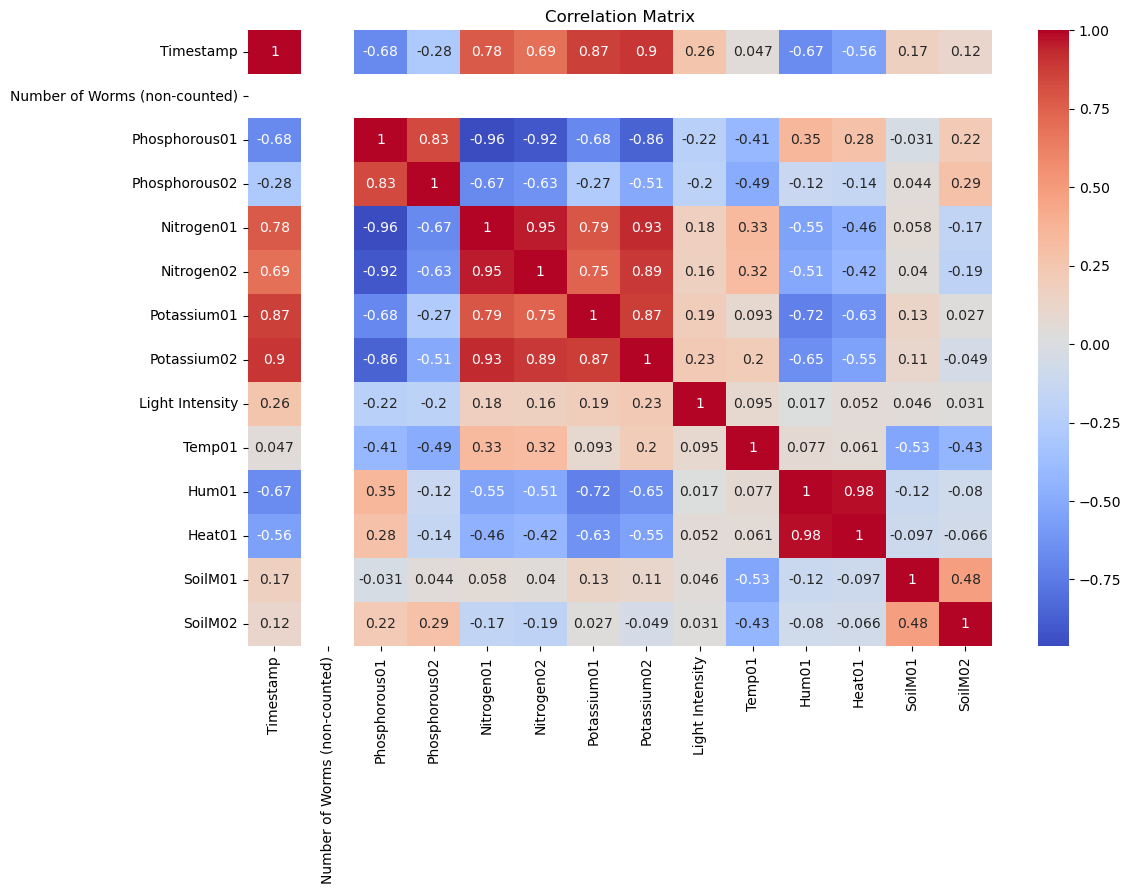

In [19]:
# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

/Users/yoland-mac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


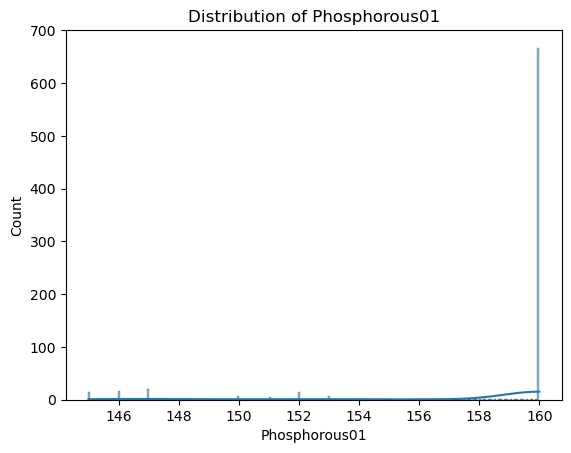

/Users/yoland-mac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


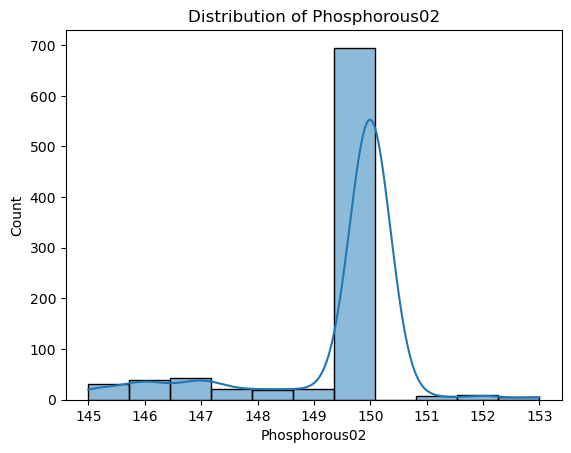

/Users/yoland-mac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


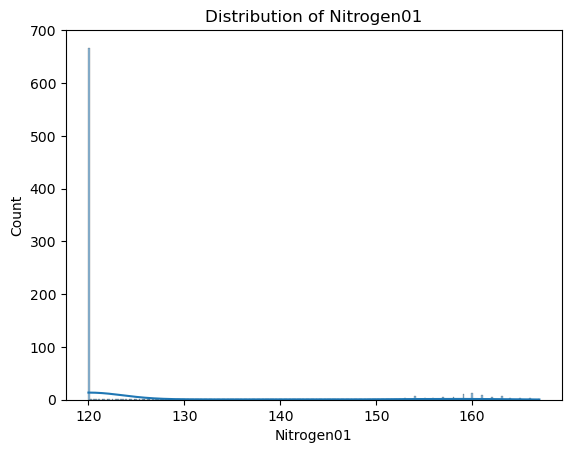

/Users/yoland-mac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


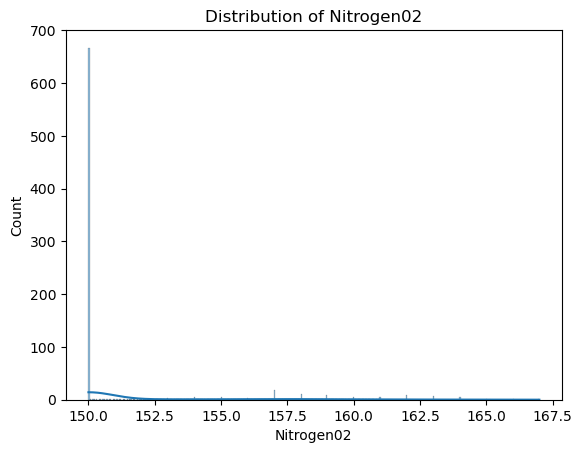

/Users/yoland-mac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


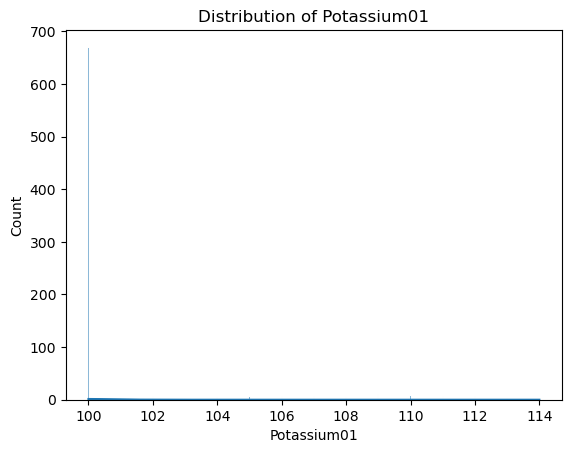

/Users/yoland-mac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


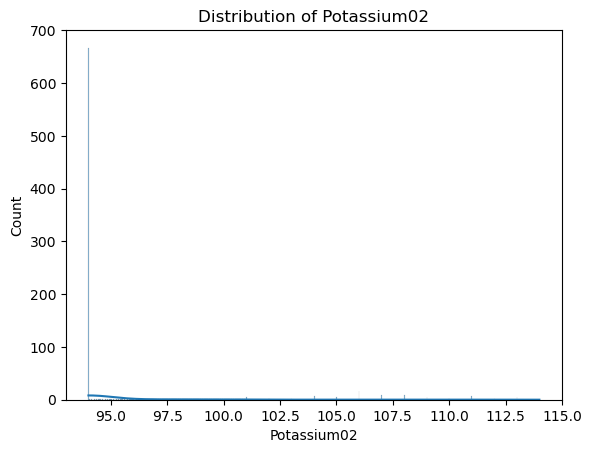

In [20]:
# Distribution of target variables
for col in ['Phosphorous01', 'Phosphorous02', 'Nitrogen01', 'Nitrogen02', 'Potassium01', 'Potassium02']:
    plt.figure()
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Feature Selection

In [21]:
# # Selecting relevant features based on correlation and domain knowledge
# features = ['Light Intensity', 'Temp01', 'Hum01', 'Heat01', 'SoilM01', 'SoilM02']
# targets = ['Phosphorous01', 'Phosphorous02', 'Nitrogen01', 'Nitrogen02', 'Potassium01', 'Potassium02']

# X = data[features]
# y = data[targets]

In [22]:
# Selecting relevant features based on correlation and domain knowledge without soil
features = ['Light Intensity', 'Temp01', 'Hum01', 'Heat01']
targets = ['Phosphorous01', 'Phosphorous02', 'Nitrogen01', 'Nitrogen02', 'Potassium01', 'Potassium02']

X = data[features]
y = data[targets]

In [23]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training and Evaluation

## Model Training Random Forest Regressor and  Multi Output Regressor

In [24]:
# Model training using Random Forest Regressor
modelrf = RandomForestRegressor(random_state=42)
modelrf.fit(X_train, y_train)

# Making predictions
y_predrf = modelrf.predict(X_test)

# Model training using Decision Tree Regressor
modelmor = DecisionTreeRegressor(random_state=42)
modelmor.fit(X_train, y_train)

# Making predictions
y_predmor = modelmor.predict(X_test)

# # Model training using LightGBM Regressor
# params = {
#     'objective': 'regression',  # Set objective to regression
#     'metric': 'mse',  # Set evaluation metric (e.g., root mean squared error)
#     'learning_rate': 0.1,  # Adjust learning rate as needed
# }
# modellgm = lgb.LGBMRegressor(**params)
# modellgm.fit(X_train, y_train)

# # Making predictions
# y_predlgm = modellgm.predict(X_test)


## Model Evaluation

In [25]:
# Evaluating the model
mserf = mean_squared_error(y_test, y_predrf)
r2rf = r2_score(y_test, y_predrf)
# Evaluating the model
msemor = mean_squared_error(y_test, y_predmor)
r2mor = r2_score(y_test, y_predmor)



print(f'Mean Squared Error Random Forest: {mserf}')
print(f'R-squared Random Forest: {r2rf}')
print(f'Mean Squared Error Decision Tree: {msemor}')
print(f'R-squared Decision Tree: {r2mor}')


Mean Squared Error Random Forest: 1.105682485181999
R-squared Random Forest: 0.8840365535719039
Mean Squared Error Decision Tree: 1.3029142598953511
R-squared Decision Tree: 0.8721521206181061


In summary, these evaluation metrics indicate that your Random Forest model is performing well:
- The Mean Squared Error (MSE) of approximately 1.1057 indicates low prediction errors on average.
- The R-squared (R2) value of approximately 0.8832 indicates that the model explains a large proportion of the variance in the target variable, demonstrating good predictive power.

# Hyperarmeter Tuning

Difine Parameter and Grid Search

In [26]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Grid search
grid_searchrf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_searchrf.fit(X_train, y_train)



Fitting 3 folds for each of 108 candidates, totalling 324 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [27]:
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize the model
# mor = DecisionTreeRegressor(random_state=42)

# # Grid search
# grid_searchmor = GridSearchCV(estimator=mor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_searchmor.fit(X_train, y_train)

# Define the parameter grid for DecisionTreeRegressor
param_grid = {
    #'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the DecisionTreeRegressor model
mor = DecisionTreeRegressor(random_state=42)

# Grid search using DecisionTreeRegressor
grid_searchmor = GridSearchCV(estimator=mor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_searchmor.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   0.0s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

## Show the Best Prameter

In [28]:
# Best parameters RF
print(f'Best parameters: {grid_searchrf.best_params_}')
# Best parameters MOR
print(f'Best parameters: {grid_searchmor.best_params_}')

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


## Model Evaluation from Best Model

In [29]:
# Evaluate the best model Random Forest
best_model = grid_searchrf.best_estimator_
y_pred_bestrf = best_model.predict(X_test)

# Evaluate the best model Multi Output Regression
best_modelmor = grid_searchmor.best_estimator_
y_pred_bestmor = best_modelmor.predict(X_test)

In [30]:
# Evaluate the model
mse_best = mean_squared_error(y_test, y_pred_bestrf)
r2_best = r2_score(y_test, y_pred_bestrf)

# Evaluate the model
mse_bestmor = mean_squared_error(y_test, y_pred_bestmor)
r2_bestmor = r2_score(y_test, y_pred_bestmor)

print(f'Mean Squared Error (best model) Random Forest: {mse_best}')
print(f'R-squared (best model) Random Forest: {r2_best}')

print(f'Mean Squared Error (best model) Decision Tree: {mse_bestmor}')
print(f'R-squared (best model) Decision Tree: {r2_bestmor}')


Mean Squared Error (best model) Random Forest: 1.0298576387454605
R-squared (best model) Random Forest: 0.8913997744109645
Mean Squared Error (best model) Decision Tree: 1.0126741666456989
R-squared (best model) Decision Tree: 0.8997750880640355


## Comparation

In [31]:
# Create a dictionary to store results
results = {
    'Model': ['Random Forest','Best Model RF','Decision Tree','Best Model DT'],
    'MSE': [mserf,mse_best, msemor,mse_bestmor],
    'R-squared': [r2rf,r2_best, r2mor,r2_bestmor]
}

# Create a DataFrame from the dictionary
df_results = pd.DataFrame(results)

# Print the DataFrame
df_results



,Model,MSE,R-squared
0,Random Forest,1.105682,0.884037
1,Best Model RF,1.029858,0.891400
2,Decision Tree,1.302914,0.872152
3,Best Model DT,1.012674,0.899775


In summary, these evaluation metrics indicate that the best model from hyperparameter tuning of Random Forest model is performing better:
- The Mean Squared Error (MSE) of approximately 1.1057 reduce to 1.0244. Lower MSE values indicate better model performance, as they suggest that the model's predictions are closer to the actual values.
- The R-squared (R2) value of approximately 0.8832 increasing 0.8932. Indicates that higher R2 values (closer to 1) indicate that the model provides a better fit to the data, meaning that it captures a larger proportion of the variance in the target variable.

# Save Model

In [32]:
# # Save the model to disk using pickle
# with open('best_model.pkl', 'wb') as file_1:
#   pickle.dump(best_model,file_1)
# with open('best_modelmor.pkl', 'wb') as file_2:
#   pickle.dump(best_modelmor,file_2)

In [ ]:
# Save the model to disk using pickle
with open('best_modelmor_save.pkl', 'wb') as file_1:
  pickle.dump(best_modelmor,file_1)